In [ ]:
import sys
sys.path.append('../')
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
#from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *

from nmf import channel_reducer

import re

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 10 # Top 10% highest l2-magnitude filters

In [4]:
def mean_direction(angles, r):
    angles = (angles)
    n = angles.shape[0]
    print(n)

    C = np.sum(r*np.cos(angles))
    S = np.sum(r*np.sin(angles))
    return C,S
    #return C,S
    print(C,S)
    if S > 0 and C > 0:
        return (np.arctan2(S,C))
    if C < 0:
        return (np.arctan2(S,C) + np.pi )
    if S<0 and C > 0:
        print(1)
        return (np.arctan2(S,C) + 2*np.pi)


 ============ LAYER -1 ==================
(3, 3, 512, 10)
(10, 3, 3, 512) (10, 3, 3, 512) (10, 3, 3, 512)
(10, 3, 3, 512) (10, 3, 3, 512) (10, 3, 3, 512)
conv1_conv
10 -1 1
251


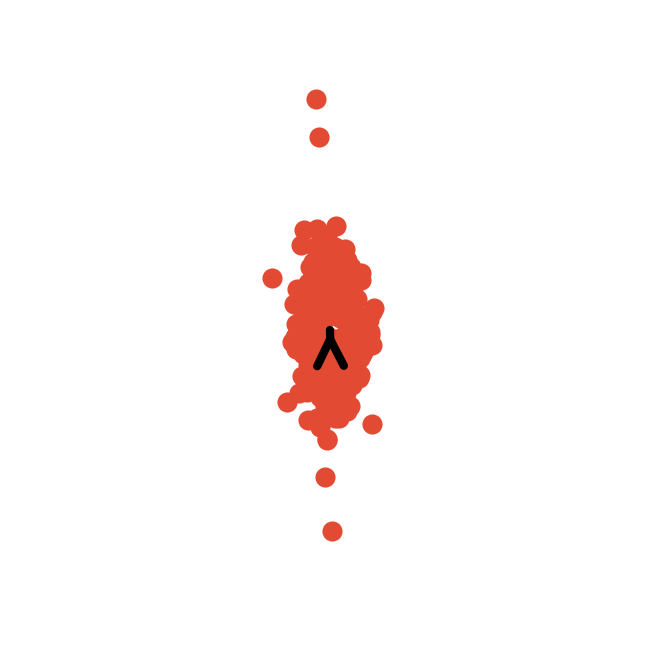

In [28]:
layers = [-1]
F = [1]

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '600'})
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (7, 7) or l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []
plt.rcParams["savefig.facecolor"] = "E5E5E5"
plt.rcParams["savefig.edgecolor"] = "E5E5E5"
fig= plt.figure(figsize = (1,1))
fig.clf()

#fig.tight_layout()
gs1 = gridspec.GridSpec(1,1)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (1,1))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)


#fig.set_tight_layout(True)
for l, l_num in enumerate(layers):
	print(f" ============ LAYER {l_num} ==================")
	top10F=topKfilters(model, l_num, k=100)[:10]
	filters = get_filter(model, l_num)[:,:,:, top10F]
	theta = getSobelTF(filters)
	print(filters.shape)
	_, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])

	dvec, dtheta = getDominantAngle(filters)

	i = F[l]
	x =a_mag[:,i]*np.cos((theta[:,i]))
	y = a_mag[:,i]*np.sin((theta[:,i]))
	#c,s = mean_direction(theta[:,i], a_mag[:,i])
	#print(d)
	lim_x = np.max(np.abs(x))
	lim_y = np.max(np.abs(y))
	lim = np.max([lim_x, lim_y])
	lim *= 1.3

	e_vec = dvec[i]

	#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
	#ax[l_num, i].set_rasterization_zorder(1)
	ax[0, l].set_xlim(-lim, lim)
	ax[0, l].set_ylim(-lim, lim)
	if l_num == 0:	
		ax[0, l].scatter(x,y, s=2, color=['red', 'green', 'blue'])
	else:
		ax[0, l].scatter(x,y, s=2, color='#E24A33')
	ax[0, l].set_box_aspect(1)

	ax[0, l].set_xticks([])
	ax[0, l].set_yticks([])
	ax[0, l].set_aspect('equal')
	#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	
	ax[0, l].annotate("", xy=(e_vec[0]*.01, e_vec[1]*.01), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))
	ax[0, l].collections[0].set_rasterized(True)

	#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")

	print(conv_layers[0].name)
	match = re.search(r"conv(\d+)_block(\d+)", conv_layers[l_num].name)
	if match is None:
		match = re.search(r"conv(\d+)_conv", conv_layers[l_num].name)
		ax[0, i].set_xlabel(f"conv{match.group(1)}, F{top10F[F[l]]}", fontsize=5) 
		continue

	print(len(top10F), l_num, F[l])
	print(top10F[F[l]])
	
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.rcParams["savefig.facecolor"] = "E5E5E5"


In [6]:
i

1

In [7]:
#fig.subplots_adjust(wspace=0.025, hspace=0.025)
#plt.show()

In [29]:
fig.savefig('resnet_one.pdf', dpi=600, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()